# importing libraries

In [1]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")
import re

# Loading data

In [2]:
cars = pd.read_csv('../../../Data/data_model.csv')

In [3]:
df_cars = cars.copy()  #makinga copy of original data set

print('Original Data Shape:',df_cars.shape)


Original Data Shape: (3813, 41)


Metric	    Target Range

MAE	          2,000–8,000

RMSE	      3,000–12,000

MAPE	      ≤15% (across all prices)

R² Score	  >0.80, ideally >0.85

# Dropping unwanted and unimportant columns

In [4]:
df_cars.columns

Index(['brand', 'model', 'model_year', 'fuel_type', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title', 'price', 'years_used', 'capacity',
       'horsepower', 'cylinder_count', 'mileage_per_year', 'mileage_sqrt',
       'mileage_with_age', 'mileage_per_year_with_age', 'mileage_brand',
       'mileage', 'brand_category', 'log_price', 'power_to_weight_ratio',
       'brand_frequency', 'model_frequency', 'brand_target_enc',
       'model_target_enc', 'mileage_per_year_sqrt', 'mileage_times_age',
       'mileage_sqrt_times_age', 'horsepower_times_cylinder_count',
       'capacity_mileage_interaction', 'age_squared', 'mileage_binned',
       'log_mileage', 'log_capacity', 'capacity_binned', 'horsepower_binned',
       'age_binned', 'trans_num', 'brand_enc'],
      dtype='object')

# XGB Regressor

In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to perform XGBoost Regression with hyperparameter tuning
def perform_xgboost_regression(df, target_column,random_state=10):
    # Splitting the data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Train-test split (80% training, 20% testing)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Scaling the features before training
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize XGBoost Regressor
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state = random_state)

    # Hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1],
    }

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best parameters and the best score
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Cross-validation Score:", grid_search.best_score_)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test_scaled)

    # Calculate the evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Relative Metrics (MAPE and sMAPE)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    smape = np.mean(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100

    # Exponentiate to get the original price scale (since log_price was used)
    y_pred_original = np.exp(y_pred)
    y_test_original = np.exp(y_test)

    # Calculate MAE, MSE, RMSE, and R² for actual prices
    mae_actual = mean_absolute_error(y_test_original, y_pred_original)
    mse_actual = mean_squared_error(y_test_original, y_pred_original)
    rmse_actual = np.sqrt(mse_actual)
    r2_actual = r2_score(y_test_original, y_pred_original)

    # Relative Metrics for actual prices
    mape_actual = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    smape_actual = np.mean(2 * np.abs(y_test_original - y_pred_original) / (np.abs(y_test_original) + np.abs(y_pred_original))) * 100

    # Results
    results = {
        "MAE (Actual Price)": mae_actual,
        "MSE (Actual Price)": mse_actual,
        "RMSE (Actual Price)": rmse_actual,
        "R² Score (Actual Price)": r2_actual,
        "MAPE (mean of absolute percentage error)": mape_actual,
        "sMAPE (same as mape but avoids division by 0)": smape_actual
    }

    return results, y_pred, y_test

# Assuming df is your DataFrame with the target column 'log_price'
col1 = ['fuel_type', 'transmission', 'capacity_binned', 'mileage_sqrt', 'years_used', 'log_price', 'brand', 'horsepower', 'brand_frequency']
#col1 =['fuel_type', 'brand','model_frequency','brand_frequency','transmission','years_used', 'capacity_binned','horsepower', 'cylinder_count','log_mileage', 'brand_category', 'log_price']
df_xgb = df_cars[col1]

# Apply one-hot encoding for categorical columns (if applicable)
categorical_columns = df_xgb.select_dtypes(include=['object', 'category']).columns.to_list()
df_xgb = pd.get_dummies(df_xgb, columns=categorical_columns, drop_first=True)

# Run XGBoost regression with hyperparameter tuning
results_xgb, y_pred, y_test = perform_xgboost_regression(df_xgb, target_column='log_price')

# Display the results
for metric, value in results_xgb.items():
    print(f"{metric}: {value}")


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max

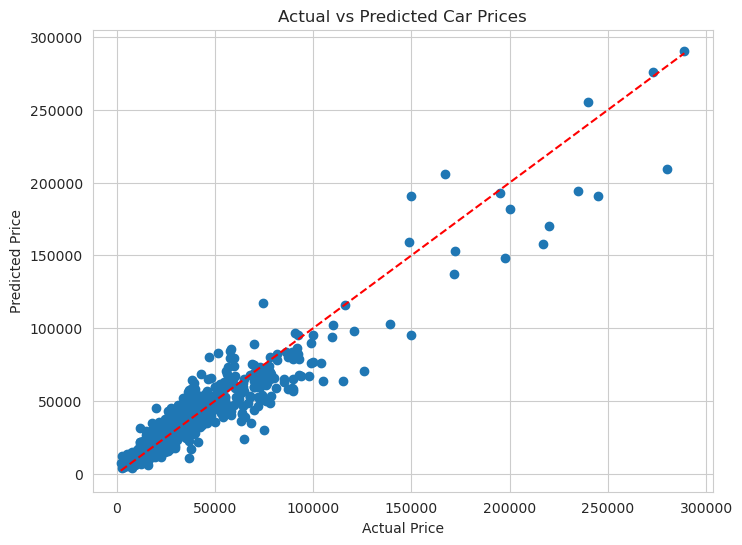

In [9]:
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.savefig('XGB_price_comparison.png')
plt.show()

In [10]:
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
outlier_mask = (residuals > mean_residual + 3 * std_residual) | (residuals < mean_residual - 3 * std_residual)


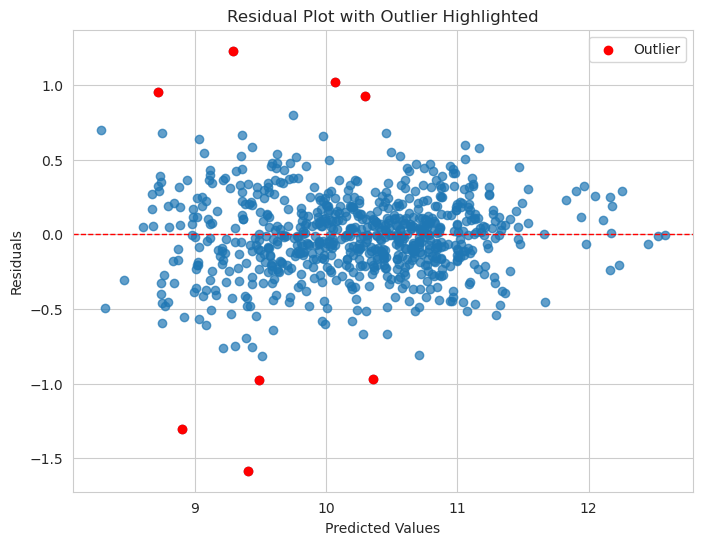

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.scatter(y_pred[outlier_mask], residuals[outlier_mask], color='red', label='Outlier')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.title("Residual Plot with Outlier Highlighted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig('XGB_residuals.png')
plt.show()

In [12]:
# Remove the outlier
y_test_filtered = y_test[~outlier_mask]
y_pred_filtered = y_pred[~outlier_mask]

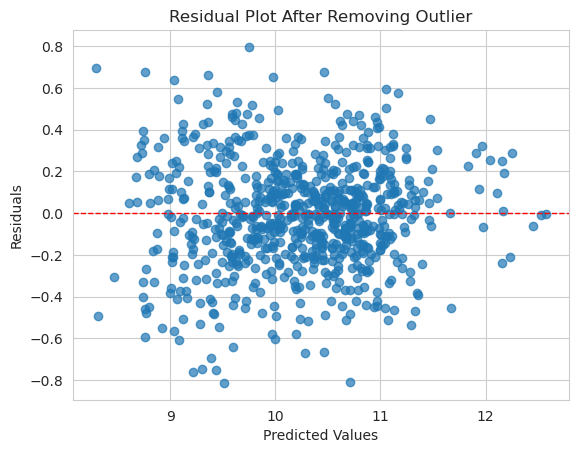

In [13]:
residuals_filtered = y_test_filtered - y_pred_filtered
plt.scatter(y_pred_filtered, residuals_filtered, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot After Removing Outlier")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [14]:
outlier_indices = np.where(outlier_mask)[0]
print("Outlier Indices:", outlier_indices)

Outlier Indices: [297 337 357 498 503 598 638 647]


In [15]:
# Assuming your dataset is in a DataFrame called df
outlier_data = df_xgb.iloc[outlier_indices]
print("Outlier Data Points:")
print(outlier_data)

Outlier Data Points:
     capacity_binned  mileage_sqrt  years_used  log_price  horsepower  \
297              4.0     48.507731         3.0  11.979805  331.515805   
337              4.0    231.531855         6.0  10.368918  331.515805   
357              2.0    163.996951         2.0  10.302297  331.515805   
498              4.0    193.891722         3.0  11.044457  331.515805   
503              6.0    119.804007         4.0  11.065090  375.000000   
598              2.0    217.866932         6.0   9.595603  147.000000   
638              2.0    277.488739        13.0  10.373522  265.000000   
647              6.0     65.459911         1.0  11.092687  331.515805   

     brand_frequency  fuel_type_Flex Fuel  fuel_type_Gasoline  \
297                9                False                True   
337              196                False                True   
357               69                False                True   
498              373                False                True

In [16]:
from scipy import stats

# Calculate z-scores
z_scores = stats.zscore(residuals)

# Identify points with z-scores greater than 3 (or less than -3, depending on threshold)
outliers = np.where(np.abs(z_scores) > 3)
print("Outlier indices:", outliers)

Outlier indices: (array([297, 337, 357, 498, 503, 598, 638, 647]),)


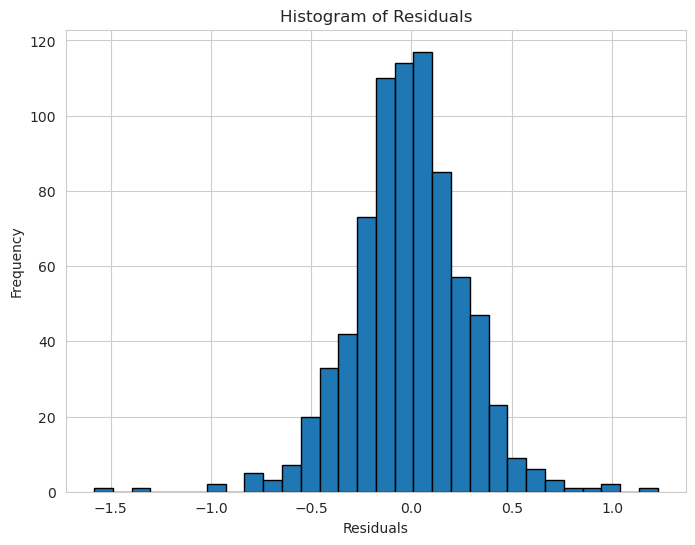

In [17]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.savefig('XGB_residual_hist.png')
plt.show()